# Simple NN

Investigate a simple feedforward NN. Look at 1 layer then multi layer?

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

from os.path import join

import sys
sys.path.append('../')
import utils

In [2]:
assert torch.cuda.is_available(), 'CUDA is not available.'

## Load Data

In [3]:
fname = join('/home/squirt/Documents/data/weather_data/', 'all_data.h5')

Set batchsize and partition. Create Dataloaders from h5 data. Use utils function

In [4]:
batch_size = 2048 
split = 0.5
t_dl, v_dl = utils.get_dataloaders(fname, batch_size, split)

## Define Model

Simple FF net. Flatten input so $(3*2*2 + 70*2*2*2)=852$. And flatten output $(70*2*2*2)=560$.

In [5]:
class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN, self).__init__()
        self.fc1 = nn.Linear(852,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 560)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Define Training Loop 

Define training loop. Does one pass over data then returns average loss
Inputs:
    - model (nn.Module): Our Net that we want to optimize
    - dl (torch.utils.data.DataLoader): Train dataloader
    - optim (torch.optim): Optimizer to train
    - loss (nn.Module): Loss function (can be nn.Module or nn.Function)
Returns:
    - Training loss on one pass


In [6]:

def train(model:nn.Module, dl:torch.utils.data.DataLoader, optim:torch.optim, loss:nn.Module) -> float:
    model.train()
    total_loss = .0
    scaler = GradScaler()

    for _, (l, x, y) in enumerate(dl):
        l = l.cuda()
        x = x.cuda()
        y = y.cuda()

        # Flatten and combine
        l = l.view(-1, 3*2*2)
        x = x.view(-1, 70*3*2*2)
        x = torch.cat((l, x), 1)

        y = y.view(-1, 70*2*2*2)

        # Forward pass
        with autocast():
            y_pred = model(x)
            l = loss(y_pred, y)
            total_loss += l.item()

        # Preform backpass
        scaler.scale(l).backward()
        scaler.step(optim)
        scaler.update()
    
    return total_loss / len(dl)

Define eval loss loop. Does one pass over evaluation data and returns the average loss
Inputs:
    - model (nn.Module): Network that we are training
    - dl (torch.utils.data.DataLoader): Eval dataloader

In [7]:
def eval(model:nn.Module, dl:torch.utils.data.DataLoader, loss:nn.Module) -> float:
    model.eval()
    total_loss = .0

    for _, (l, x, y) in enumerate(dl):
        l = l.cuda()
        x = x.cuda()
        y = y.cuda()

        # Flatten and combine
        l = l.view(-1, 3*2*2)
        x = x.view(-1, 70*3*2*2)
        x = torch.cat((l, x), 1)

        y = y.view(-1, 70*2*2*2)

        # Forward pass
        with autocast():
            y_pred = model(x)
            l = loss(y_pred, y)
            total_loss += l.item()

    return total_loss / len(dl)

## Training

In [8]:
loss_fn = nn.MSELoss()
model = simpleNN()
model = model.double().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Early Stopping

In [9]:
eval_loss = -1*float('inf') 
train_loss  = float('inf') 
i = 0
while train_loss > eval_loss:
    i+=1
    train_loss = train(model, t_dl, optimizer, loss_fn)
    eval_loss = eval(model, v_dl, loss_fn)
    print(f'Epoch {i} - Eval Loss: {eval_loss}')

Epoch 1 - Eval Loss: 401839.2971556643
Epoch 2 - Eval Loss: 9745.142945767375
Epoch 3 - Eval Loss: 1263.623579150259
Epoch 4 - Eval Loss: 473.5684682326454
Epoch 5 - Eval Loss: 197.84183653181023
Epoch 6 - Eval Loss: 67.05986976414465
Epoch 7 - Eval Loss: 25.45300772860413
Epoch 8 - Eval Loss: 11.03458812740317
Epoch 9 - Eval Loss: 5.665998574907411
Epoch 10 - Eval Loss: 3.3612550906339806
Epoch 11 - Eval Loss: 2.8662653200862778
Epoch 12 - Eval Loss: 2.2793963496022944
Epoch 13 - Eval Loss: 1.7336760701867129
Epoch 14 - Eval Loss: 1.4612049707749413
Epoch 15 - Eval Loss: 1.1852280266749224
Epoch 16 - Eval Loss: 0.9620270036869145
Epoch 17 - Eval Loss: 0.870104247061629
Epoch 18 - Eval Loss: 0.7885044916522775
Epoch 19 - Eval Loss: 0.7145633196618155
Epoch 20 - Eval Loss: 0.6748528394582192
Epoch 21 - Eval Loss: 0.608167704228038
Epoch 22 - Eval Loss: 0.5691204955485508
Epoch 23 - Eval Loss: 0.5237049784622044
Epoch 24 - Eval Loss: 0.4810486019865691
Epoch 25 - Eval Loss: 0.44641534303

Cross fold validation

In [10]:
folds = 5
results_dict = {}
for i in range(folds):
    loss_fn = nn.MSELoss()
    model = simpleNN()
    model = model.double().cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early Stopping 
    eval_loss = -1*float('inf') 
    train_loss  = float('inf') 
    i = 0
    train_loss_record = []
    eval_loss_record = []
    while train_loss > eval_loss:
        i+=1
        train_loss = train(model, t_dl, optimizer, loss_fn)
        eval_loss = eval(model, v_dl, loss_fn)

        train_loss_record.append(train_loss)
        eval_loss_record.append(eval_loss)
    results_dict[i] = (train_loss_record, eval_loss_record)


## Graphing

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import copy

rec_test = copy.deepcopy(results_dict)

In [37]:
def plot_results(results:dict):
    '''
    Plot results on a log scale for better visualization, with error bars
    Inputs:
        - results: dict of results from the training loop (fold:(train_loss, eval_loss))
    '''
    # Get mean and std for each epoch as long as they exist
    def create_epoch_dict(results:dict) -> dict:
        epoch_dict = {}
        e = 0
        while True:
            e+=1
            try:
                rec_test = np.array([results[i][1].pop(0) for i in results.keys()])
                rec_train = np.array([results[i][0].pop(0) for i in results.keys()])
                epoch_dict[e] = {
                    'train': (np.mean(rec_train), np.std(rec_train)),
                    'eval': (np.mean(rec_test), np.std(rec_test))
                }
            except:
                raise ValueError('Results dict is not formatted correctly.')

            for k in list(results.keys()):
                if len(results[k][0]) == 0:
                    del results[k]

            if len(results.keys()) == 0:
                break

        return epoch_dict        
    
    # Create the epoch dict
    error_dict = create_epoch_dict(results)

    # Plot the results
    labels = list(error_dict.keys())
    
    # Train
    train_means = [error_dict[k]['train'][0] for k in error_dict.keys()]
    train_std_devs = [error_dict[k]['train'][1] for k in error_dict.keys()]
        
    # eval 
    eval_means = [error_dict[k]['eval'][0] for k in error_dict.keys()]
    eval_std_devs = [error_dict[k]['eval'][1] for k in error_dict.keys()]

    # Set fig size so can read x axis
    plt.figure(figsize=(20, 10))

    # Plot training means with error bars
    plt.errorbar(range(len(train_means)), train_means, yerr=train_std_devs, fmt='o', label='Train', ecolor='blue')

    # Plot evaluation means with error bars
    plt.errorbar(range(len(eval_means)), eval_means, yerr=eval_std_devs, fmt='o', label='Eval', ecolor='orange')

    plt.xticks(range(len(labels)), labels)
    plt.legend()

    # Set scales
    plt.yscale('log')
    plt.tight_layout()

    plt.show()
    

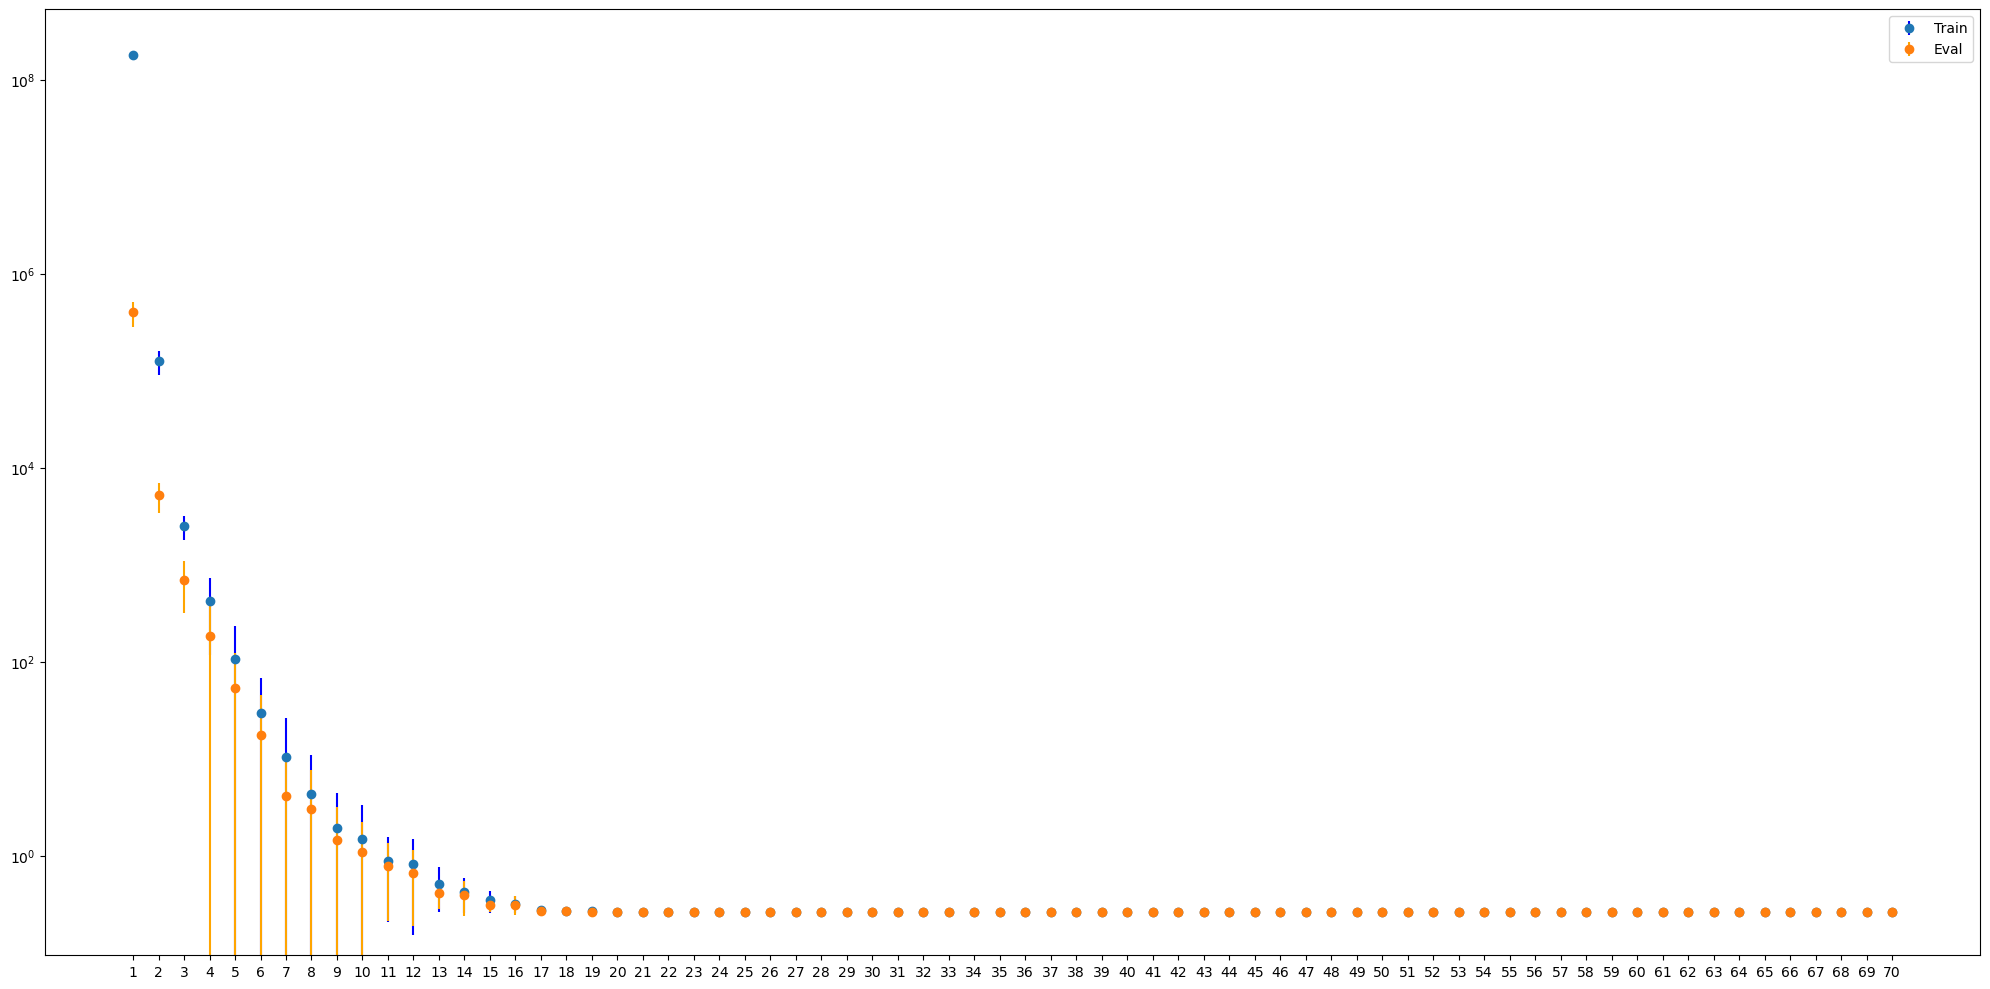

In [39]:
plot_results(rec_test)